# 프로젝트 : CIFAR-10 이미지 생성하기
***
###<목차>
##### STEP 1. 작업환경 구성하기
##### STEP 2. 데이터셋 구성하기
##### STEP 3. 생성자 모델 구현하기
##### STEP 4. 판별자 모델 구현하기
##### STEP 5. 손실함수와 최적화 함수 구현하기
##### STEP 6. 훈련과정 상세 기능 구현하기
##### STEP 7. 학습 과정 진행하기
##### STEP 8. (optional) GAN 훈련 과정 개선하기
##### 🤔회고🤔
##### Reference

***
# STEP 1. 작업환경 구성하기


In [ ]:
! pip list | grep -E 'imageio|Pillow'

imageio                       2.4.1
Pillow                        7.1.2


In [ ]:
! pip install imageio
! pip install Pillow

In [ ]:
! mkdir -p /content/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p /content/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p /content/aiffel/dcgan_newimage/cifar10/training_history

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.7.0


# STEP 2. 데이터셋 구성하기

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


## 데이터 정규화

In [ ]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
#데이터 shape 살펴보기
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


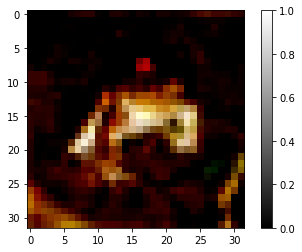

In [ ]:
#데이터 생김새 확인하기
plt.imshow(train_x[0].reshape(32, 32, 3), cmap='gray')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

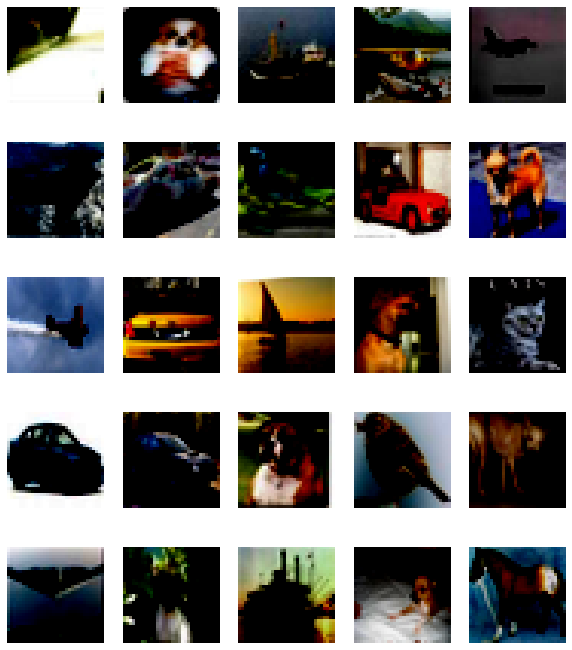

In [ ]:
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

#train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고,
#이를 배치 사이즈에 따라 나누도록 함
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

# ❗ 일단 아래 코드는 참고만

In [ ]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(train_x, train_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

# STEP 3. 생성자 모델 구현하기

In [ ]:
def make_generator_model(in_shape=(32, 32, 3)):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum = 0.99))
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.99))
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.99))
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
def make_generator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*64*8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    # model.output_shape == (BACHE_SIZE, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha)) 

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

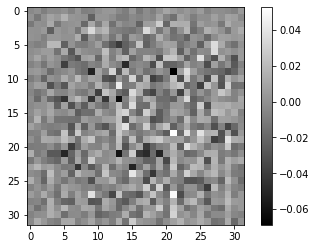

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

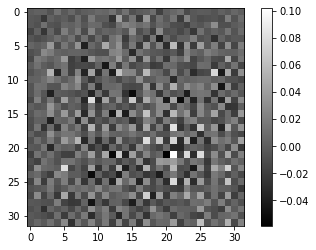

In [ ]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# STEP 4. 판별자 모델 구현하기

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
#    model.add(layers.BatchNormalization(momentum = 0.99))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
#    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
# 아까 생성한 가짜 이미지 입력!
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00171041]], dtype=float32)>

# STEP 5. 손실함수와 최적화 함수 구현하기
## 손실함수

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
#discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 최적화 함수

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 6. 훈련과정 상세 기능 구현하기

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- def generate_and_save_images(model, epoch, it, sample_seeds, dirno=1) : 훈련하면서 생성한 이미지를 시각화하는 함수.
- -1~1 사이로 정규화했던 데이터 셋을 다시 돌려놓는다.

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds, dirno=1):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
#        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
#        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8')) #(-1,1)로 정규화를 다시 (0,255)로
        plt.axis('off')
   
    plt.savefig('/content/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))
#    plt.savefig('/content/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
#                    .format(os.getenv('HOME'), epoch, it))


    plt.show()

## 우수 참고
- color='lightseagreen' 넣었음

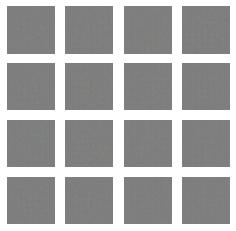

In [ ]:
generate_and_save_images(generator, 30, 1, seed)

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(epoch))
#    plt.savefig('/content/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
#                    .format(os.getenv('HOME'), epoch))
    plt.show()

###체크포인트

In [ ]:
checkpoint_dir = '/content/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7. 학습 과정 진행하기
- dirno, genno, disno 넣어줌


In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

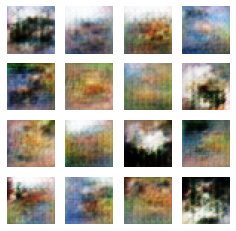

Time for training : 1682 sec


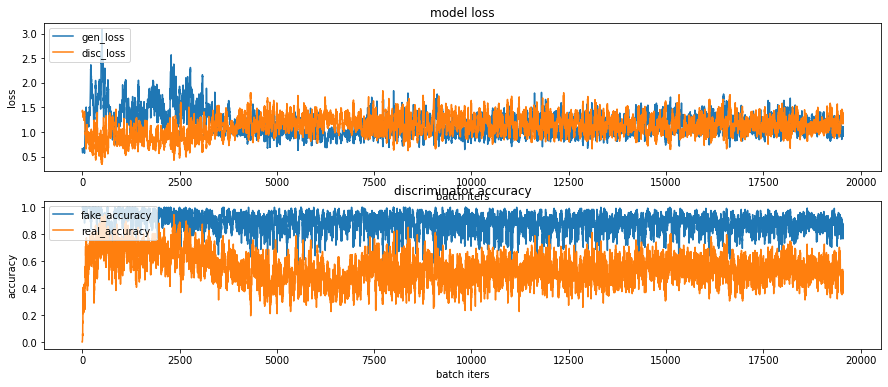

CPU times: user 28min 7s, sys: 30.3 s, total: 28min 37s
Wall time: 28min 4s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 학습과정 시각화

In [ ]:
anim_file = '/content/aiffel/dcgan_newimage/cifar10/CIFAR_04.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format())
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/aiffel/dcgan_newimage/cifar10/CIFAR_04.gif

-rw-r--r-- 1 root root 1862631 Feb 15 12:28 /content/aiffel/dcgan_newimage/cifar10/CIFAR_04.gif


# STEP 8. (optional) GAN 훈련 과정 개선하기
|   NO    |변경사항|문제점 및 분석|gif|
|---|---|--|--|
|01|base code|기존 code를 그대로 사용하였더니 컬러 이미지임에도 흑백 결과가 나왔다.|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_01.gif?raw=true)width="30" height="30"|
|02|STEP6에서 정규화를 다시 역정규화 시켜줌|컬러 전환 완료|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_02.gif?raw=true)width="30" height="30"|
|03|  BatchNormalization 0.99, dropout 0.5 설정|좀 더 선명해진 느낌...?|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_03.gif?raw=true)width="30" height="30"|
|04|BATCH_SIZE = 256 => BATCH_SIZE = 128, dropout제거|위에 버전보다는 나름 형태가 보이는 듯(?)하다. 내 느낌인가..?   </br>여튼 모델이 deep할 수록 성능이 개선된다고 하기에 model layer을 추가해주고 싶다.|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_04.gif?raw=true)width="30" height="30"|



# 🤔회고🤔
### <루브릭 평가 지표>
|   평가문항    |상세기준|
|---|---|
|1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|

### <이번 프로젝트에서 어려웠던 점>

### <프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점>
1. BatchNormalization와 Dropout 적용   
(1) BatchNormalization   
- BatchNormalization는 Convoluter Layer 또는 Fully Connected Layer 등의 layer 뒤에 적용되는 것이 좋다.
- ReLU와 같은 Activation function을 적용하기 전에 적용하는 것을 추천
- alpha는 Momentum이란 계수로 보통 0.9, 0.99, 0.999와 같이 1에 가까운 값을 사용함   
(2) Dropout   
- Dropout은 activation function을 적용한 뒤에 적용하는 것이 좋다.

2. ㅗ

### <루브릭 평가 지표를 맞추기 위해 시도한 것들>
1. 모델 깊이 deep하게 하기   
=> 참고자료에서 deep할 수록 좋다고 하여 처음부터 모델을 만지고 싶었으나 정보가 많이 없어 시도하기 어려웠다.   
2. BATCH_SIZE 조절   

### <만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정>

### <자기 다짐>

- plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))

# Reference
1. BatchNormalization, Dropout, Pooling 적용 순서 : https://gaussian37.github.io/dl-concept-order_of_regularization_term/
2. BatchNormalization momentum : https://junhyukso.github.io/post/bn_v1/
3. DCGAN Tuning Tips : https://seing.tistory.com/110
